# Importando Bibliotecas

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

# Funções Auxiliares

In [69]:
def dataFrame_to_boxPlot(dataFrame,var):
    data = {}
    column_value = []
    column_x = []

    for column in range(len(dataFrame.columns)):
        column_value += list(dataFrame.iloc[:,column])
        column_x += [f'x{column+1}' for i in range(len(dataFrame))]

    data[var]=column_value
    data['x']=column_x
    return pd.DataFrame(data)

In [70]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(len(dataframe.iloc[0,0])):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

# Importando Dados

In [71]:
past = 'C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Previsoes/'

In [72]:
previsoes_np = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()


,demandas
0,"[89.54093933105469, 89.2696304321289, 90.06903..."
1,"[89.57524108886719, 89.31195831298828, 90.1138..."
2,"[89.56161499023438, 89.27366638183594, 90.0719..."
3,"[89.56279754638672, 89.28074645996094, 90.0748..."
4,"[89.56739044189453, 89.32603454589844, 90.1259..."


In [73]:
len(previsoes_np.iloc[1,0])

17

In [74]:
previsoes_sar = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_sar/Previsao_sar{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_sar['demandas'] = previsoes
previsoes_sar = pd.DataFrame(previsoes_sar)

In [75]:
dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')
demandas_aux = pd.read_csv('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Demandas_treinamento/demandas',parse_dates=['date'],date_parser=dateparse)
demandas = {}
  

filtro_string = [f'(date>="201{i}/01/01" and date<"201{i}/05/01")' for i in range(5,9)]
filtro = filtro_string[0]+'or'+filtro_string[1]+'or'+filtro_string[2]+'or'+filtro_string[3]

df_demandas = demandas_aux.copy()
demandas_aux.query(filtro,inplace=True)

demandas = {}
demandas_quadrimestre = []
for i in range(5,9): 
    demandas_quadrimestre.append(list(demandas_aux.query(f'date>="201{i}/01/01" and date<"201{i+1}/01/01"')['demandas']))

demandas['demandas'] = demandas_quadrimestre
demandas = pd.DataFrame(demandas)
demandas.iloc[0,0] = demandas.iloc[0,0][:17]

C:\Users\marcio\AppData\Local\Temp\ipykernel_112\311545033.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse= lambda dates:pd.datetime.strptime(dates,'%Y-%m-%d')


In [76]:
with open('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_sarima.txt', "r") as arquivo:
	test_sar = [float(demanda) for demanda in arquivo.read().split(',')]

with open('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Prev_teste/test_pro.txt', "r") as arquivo:
	test_np = [float(demanda) for demanda in arquivo.read().split(',')]


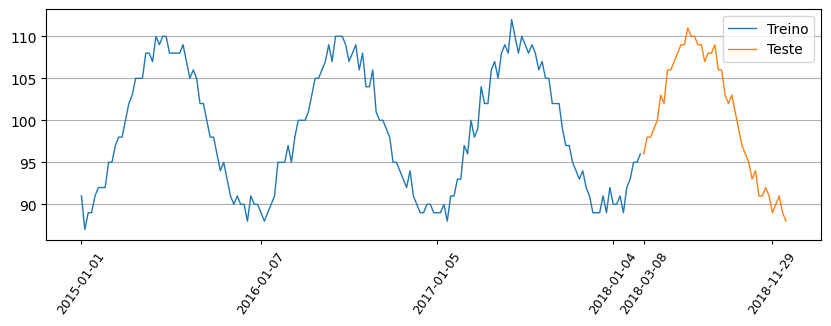

In [77]:
df_train, df_test =df_demandas.iloc[:166],df_demandas.iloc[166:]

fig=plt.figure(figsize=(10,3))

ax=fig.add_subplot(1,1,1)
plt.plot(df_train.date,df_train.demandas,label='Treino', linewidth=1)
plt.plot(df_test.date,df_test.demandas,label='Teste', linewidth=1)
plt.xticks([df_demandas.iloc[i,1] for i in [0,53,105,157,166,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
plt.legend()
plt.grid(axis='y')
for tick in ax.get_xticklabels():
    tick.set_rotation(55)

#plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/DemandasTreinoTeste.png', bbox_inches='tight',pad_inches = 0.1,format='png')

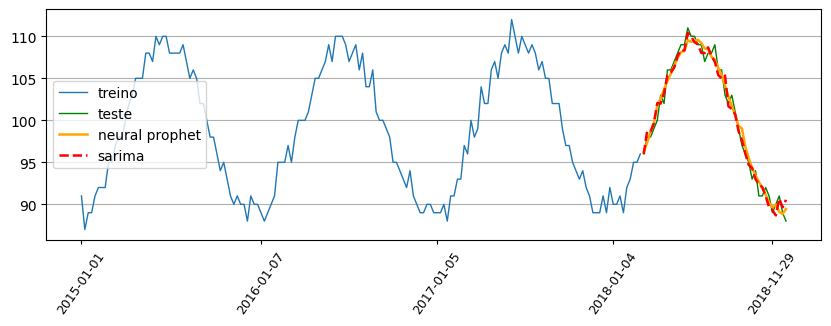

In [78]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,1,1)

plt.plot(df_demandas.date.iloc[:166],df_demandas.demandas.iloc[:166],label='treino', linewidth=1)
plt.plot(df_demandas.date.iloc[166:],df_demandas.demandas.iloc[166:],label='teste', linewidth=1,color='green')

plt.plot(df_demandas.date.iloc[166:],test_np,label='neural prophet', linewidth=1.8,color='orange')
plt.plot(df_demandas.date.iloc[166:],test_sar,label='sarima', linestyle='--',linewidth=1.8,color='red')
plt.xticks([df_demandas.date.values[i] for i in [0,53,105,157,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.grid(axis='y')
plt.legend()


#plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/prev_testes.png', bbox_inches='tight',pad_inches = 0.1,format='png')


# Analise Das Previsões

In [79]:
ic_np = pd.read_csv('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Intervalos_Confianca/NP/IC_NP0')
ic_sa = pd.read_csv('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/tabelas/Intervalos_Confianca/SA/IC_SA0')

In [80]:
previsao_demanda_np = describe_var(previsoes_np,'demandas')
previsao_demanda_sar = describe_var(previsoes_sar,'demandas')
demandas_d = describe_var(demandas,'demandas')

In [81]:
boxPlot_previsao_np = dataFrame_to_boxPlot(previsao_demanda_np,'demandas')
boxPlot_previsao_sar = dataFrame_to_boxPlot(previsao_demanda_sar,'demandas')
boxPlot_demandas = dataFrame_to_boxPlot(demandas_d,'demandas')
boxPlot_demandas['year'] = [2015+j for i in range(17) for j in range(4)]

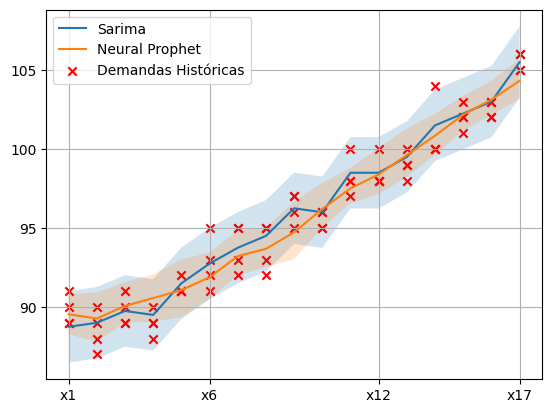

In [82]:
plt.fill_between([f'x{i}' for i in range(1,18)], ic_sa['upper demandas'], ic_sa['lower demandas'],
                alpha=0.2, interpolate=True)
plt.plot([f'x{i}' for i in range(1,18)],previsoes_sar['demandas'].iloc[0],label='Sarima')
plt.fill_between([f'x{i}' for i in range(1,18)], ic_np['yhat1 5.0%'], ic_np['yhat1 95.0%'],
                alpha=0.2, interpolate=True)
plt.plot([f'x{i}' for i in range(1,18)],previsoes_np['demandas'].iloc[0],label='Neural Prophet')
plt.xticks([0,5,11,16])
plt.scatter(boxPlot_demandas['x'],boxPlot_demandas['demandas'],marker='x',color='red',label='Demandas Históricas')
plt.grid(axis='both')

plt.legend()
plt.savefig('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/img/IC.png', format='png', bbox_inches='tight',pad_inches = 0.1)

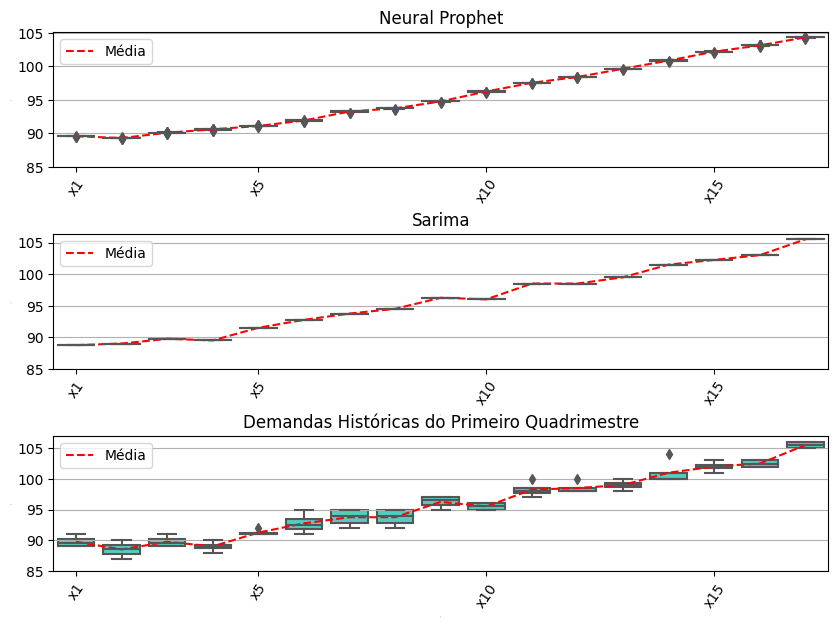

In [83]:
fig=plt.figure(figsize=(10,7))
#fig.suptitle('Distribuição das Previsões de Demandas por Período')



plt.subplots_adjust(wspace=0, hspace=0.5)

ax=fig.add_subplot(3,1,1)
ax.set_title('Neural Prophet')
sns.boxplot(data=boxPlot_previsao_np,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_np.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.grid(axis='y')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_np.columns)/5)+1)])
plt.yticks([85,90,95,100,105])
plt.legend()


ax=fig.add_subplot(3,1,2)
ax.set_title('Sarima')
sns.boxplot(data=boxPlot_previsao_sar,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_sar.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.grid(axis='y')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(previsao_demanda_sar.columns)/5)+1)])
plt.yticks([85,90,95,100,105])
plt.legend()

ax=fig.add_subplot(3,1,3)
ax.set_title('Demandas Históricas do Primeiro Quadrimestre')
sns.boxplot(data=boxPlot_demandas,x='x',y='demandas',color='turquoise')
plt.plot(demandas_d.columns,demandas_d.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.grid(axis='y')
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.xticks([0]+[i*5-1 for i in range(1,int(len(demandas_d.columns)/5)+1)])
plt.yticks([85,90,95,100,105])
plt.legend()

plt.savefig('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/img/Previsoes.png', format='png', bbox_inches='tight',pad_inches = 0.1)

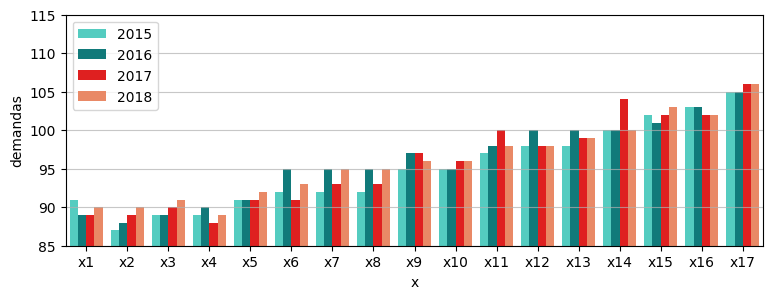

In [84]:
fig=plt.figure(figsize=(9,3))
paleta = ['turquoise','darkcyan','red','coral','khaki']

sns.barplot(data=boxPlot_demandas, x="x", y="demandas", hue="year",palette=paleta)
plt.ylim(85,115)
plt.yticks([85,90,95,100,105,110,115])

plt.legend()
plt.grid(axis='y',alpha=0.7)
plt.savefig('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/img/demandasPrimeiroQuadrimestre.png', format='png', bbox_inches='tight',pad_inches = 0.1)
plt.show()

In [85]:
demandas_d[['demandas5','demandas11','demandas12','demandas14']]

,demandas5,demandas11,demandas12,demandas14
0,91,97,98,100
1,91,98,100,100
2,91,100,98,104
3,92,98,98,100
